# MesaNet

MesaNet is a novel architecture for sequence modeling that aims to overcome the linear scaling memory and compute requirements of traditional causal transformer architectures during inference. It introduces a Mesa layer, which is a numerically stable, chunkwise parallelizable recurrent neural network (RNN) layer.

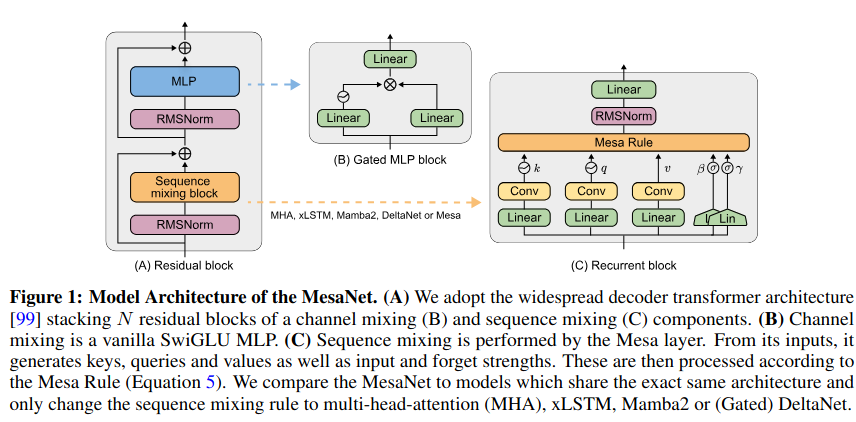

The key features of MesaNet:

**Optimal Test-Time Training**:

Unlike other RNNs that approximate an in-context regression objective through online learning rules (like gradient descent), the Mesa layer minimizes an in-context loss function to optimality at every time point. This allows it to retain past information and adapt to new evidence quickly as a sequence unfolds.

It defines the linear map (Φ<sub>t</sub>) as the solution to a cumulative regularized squared-error loss, taking into account all data seen so far (e1:t).

This optimization problem is solved using a fast Conjugate Gradient (CG) solver for a linear system of equations (linsolve(H<sub>h,t</sub> + Λ<sub>h</sub>, q<sub>h,t</sub>)), where H<sub>h,t</sub> is a state variable maintained through a linear recurrence, representing an accumulation of past key-key outer products; Λ<sub>h</sub> - regularization parameter, q<sub>h,t</sub> - query vector for head h at time t. E.g. at each step a linear system of equations is solved to find optimal q<sub>t</sub><sup>*</sup>

**Recurrent Neural Network (RNN) with Constant Complexity**:

MesaNet is part of a stream of work on RNN models that achieve constant memory and compute costs during inference, a significant advantage over Transformers, especially for autoregressive tasks like language modeling.

It processes sequences by representing and learning a linear model in its activations, similar to "fast weight programming layers".

**Chunkwise Parallelizable Design**:

The Mesa layer is designed to be parallelizable over sequence length, allowing for efficient training by leveraging matrix multiplication accelerators like GPUs and TPUs. This is achieved by exploiting an equivalence of the CG method over multiple time steps with gated linear self-attention.

**Dynamic Test-Time Compute Allocation**:

A significant feature is its ability to dynamically adapt its computational cost at test time based on the sequence being processed.

The number of CG steps required to reach a desired error tolerance (ϵ) is generally head-, sequence-, and token-specific, allowing the Mesa layer to exhibit dynamic inference costs. This means it can trade off test-time compute for performance. For example, using a dynamic stopping criterion of ϵ = 10^-4 can achieve performance on par with a fixed 30 CG steps, while reducing the average CG steps to approximately 9.

**Mesa Rule, optimization problem**:

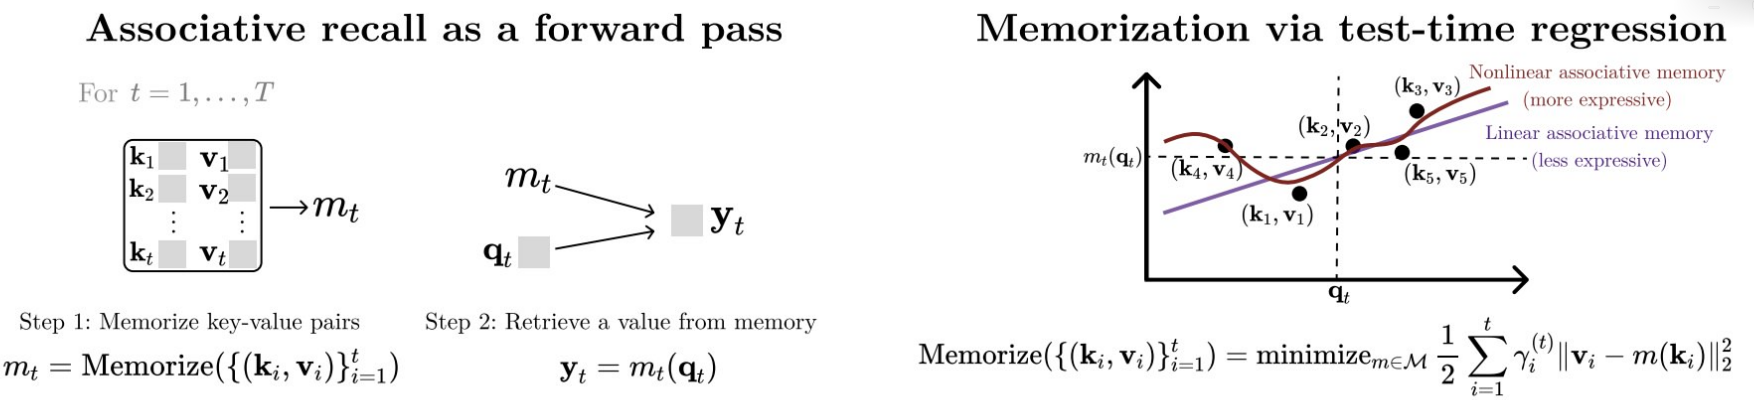

Mesa layer updates tokens according to the linear self-attention rule 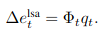 (∆e<sub>t</sub><sup>lsa</sup> - output embedding of linear self-attention, q<sub>t</sub> - query embedding) but now defines
the linear map Φ<sub>t</sub> as the solution of a test-time optimization problem, where Λ plays the role of
a quadratic regularizer:

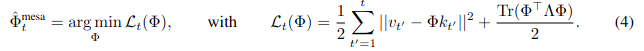

Instead of considering an instantaneous loss measured only at the current input e<sub>t</sub>, the Mesa layer optimizes the cumulative regularized squared-error loss taking into account all data e<sub>1:t</sub> so far. While at first this may seem impossible to achieve under a constant memory requirement, the Mesa layer circumvents the need to explicitly keep past tokens in memory (as in softmax self-attention) and exploits the fact that L<sub>t</sub> is a quadratic function of Φ. Second, instead of taking a single gradient descent step, the Mesa layer learns Φ to optimality at every time point.

But this original version of the layer is not parallelizable, and it therefore heavily underutilizes current matrix-matrix multiplication accelerators such as GPUs and TPUs during training.

**Mesa Rule, the solution**:
    
So, in practice, Mesa layer output (∆emesa t) is computed by summing over multiple heads, each involving a linsolve operation: 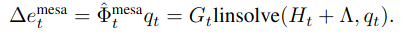

It maintains two crucial state variables, G<sub>h,t</sub> and <sub>h,t</sub>, which are updated using linear recurrence relations involving forget gates (γh,t) and input gates (βh,t):

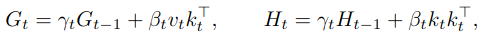

v<sub>t</sub> - values vector at time t, k<sub>t</sub> - key vector at time t

Input and forget gates (β<sub>t</sub>, γ<sub>t</sub>) are functions of the current input and are bounded within to improve performance. The forget gate γ<sub>t</sub> is upper-bounded (e.g., 0.9975) and adjusted based on input strength for numerical stability.

Regularization parameters (Λ<sub>h</sub>) are applied to the linear system and are passed through a softplus function to ensure positivity. These parameters are generally fixed over time and lower-bounded (e.g., 0.25) to control the condition number.

Input embeddings undergo RMS Normalization. Keys (k<sub>t</sub>), queries (q<sub>t</sub>), and values (v<sub>t</sub>) are generated via linear projections, convolved in time, and then keys and queries are L2-normalized after a SiLU non-linearity.

**Performance on Benchmarks**:

Synthetic Tasks: MesaNet excels at synthetic tasks like RegBench and MAD, outperforming other linear transformer alternatives and performing on par with Transformers on RegBench.

Language Modeling: MesaNet and its hybrid variant, Hawk-MesaNet, achieve lower validation perplexity on the SlimPajama dataset compared to other RNN models like Mamba2, xLSTM, and DeltaNet, and can match or even surpass Transformer baselines in average per-token perplexity.

Context Understanding: It shows strong performance early in sequences and extends its advantage in language modeling beyond 512 tokens compared to other recurrent models. On global downstream benchmarks requiring longer contexts, MesaNet outperforms other recurrent models, though it might still underperform the transformer baseline.

In-Context Recall: MesaNet generally outperforms other recurrent models and even exceeds SWA-1024, but a gap remains with Transformer baselines.

Few-Shot Learning: It demonstrates strong performance on word scrambling tasks, often outperforming the Transformer, but typically fails to match Transformer performance on translation tasks.

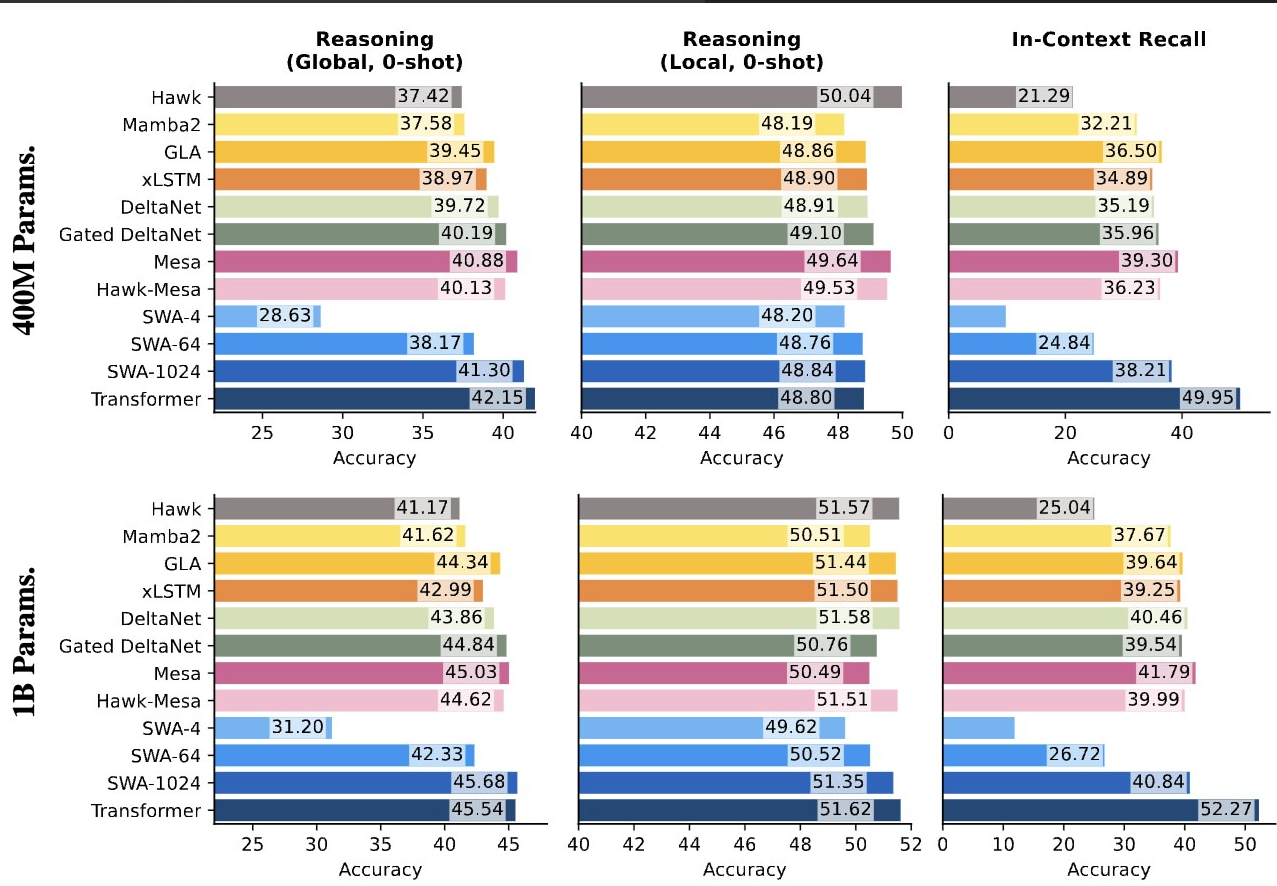

# Mixture-of-Recursions (MoR)

Main idea: recursion transformer, where every token passes through layer not only one time - at the output of the layer there is a router which can turn back the token and make it pass this layer one more time and then again up to 𝑁𝑟 times.

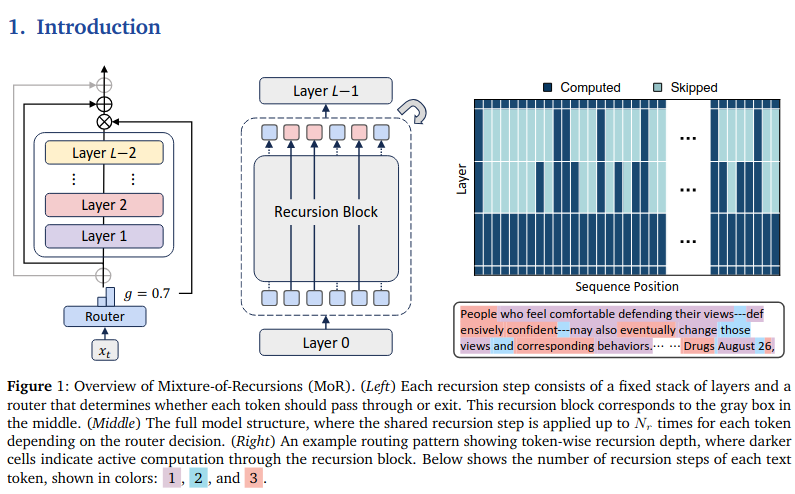

## Routing Mechanism
 
This mechanism dynamically assigns different recursion depths to individual tokens, allowing the model to focus computational resources where they are most needed.

There are two types of routing

### Parameter-sharing strategies

There are four parameter-sharing strategies: *Cycle*, *Sequence*, and their variants *Middle-Cycle* and *Middle-Sequence*

In Cycle sharing, recursion blocks are reused cyclically. For example, consider an original non-recursive model with 𝐿=9 layers and its recursive counterpart using 𝑁𝑟 =3 recursions. Under the “Cycle” strategy, the layers are shared and unrolled as [(0, 1, 2), (0, 1, 2), (0, 1, 2)]. In “Sequence” sharing, each recursion block reuses the same layer consecutively before moving to the next, resulting in [(0, 0, 0), (1, 1, 1), (2, 2, 2)] for the same configuration. Both have the same effective number of layers when unrolled (𝐿=9), but with a different order. The “Middle” variants preserve full-capacity parameters at the first and last layers (Φ<sub>0</sub> and Φ<sub>𝐿−1</sub>), while sharing weights among the intermediate layers.

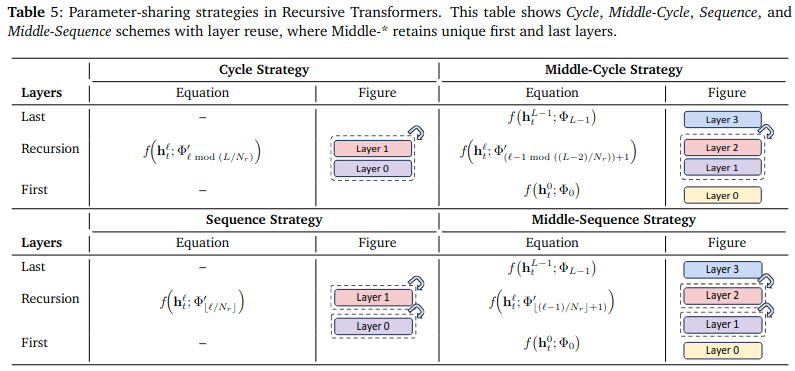

Cycle sharing generally demonstrates superior performance compared to pure Sequence sharing. Middle-Cycle is consistently the most effective parameter sharing strategy overall.

### Expert-choice routing (Figure 2a)

Involves a router at each recursion step selecting a top-𝑘 subset of tokens to continue processing, progressively narrowing the set of active tokens as depth increases. This strategy guarantees perfect load balancing but can suffer from causality violation during training, which is mitigated by auxiliary routers or auxiliary loss

### Token-choice routing (Figure 2b)

Commits each token to a fixed number of recursion blocks from the outset based on a single routing decision. This avoids causality issues but can lead to load imbalance, requiring balancing losses or loss-free algorithms for mitigation.

## KV Caching Strategies

MoR models are designed with tailored Key-Value (KV) caching strategies to address the challenge of KV cache consistency and memory footprint in dynamic-depth models.

### Recursion-wise KV caching (Figure 2c–Top)

Selectively stores KV pairs only for tokens routed to a given recursion step, restricting attention to these locally cached tokens. This reduces KV cache size, improves memory efficiency, and decreases I/O demands.

### Recursive KV sharing (Figure 2c–Bottom)

Reuses KV pairs from the first recursion step across all subsequent recursions, achieving maximal memory savings and speeding up prefill operations. However, it may lead to performance degradation in expert-choice routing due to potential context mismatches

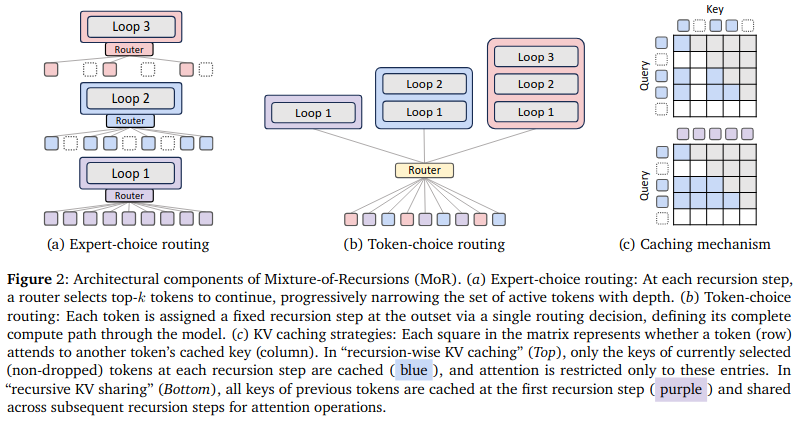

## Comparsion of routing and KV caching strategies

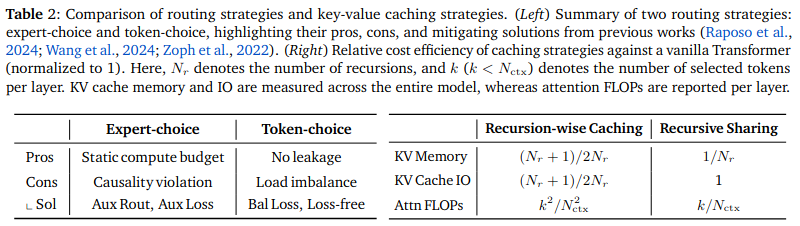

## Improved Performance
 
Across model scales from 135M to 1.7B parameters, MoR sets a new Pareto frontier by significantly lowering validation perplexity and improving few-shot accuracy compared to vanilla and existing recursive baselines, often with smaller model sizes and equal training FLOPs. For example, MoR can achieve superior performance with nearly 50% fewer parameters under the same FLOPs budget, or with 25% fewer training FLOPs at equal data.

## Experiments

MoR models with expert-choice routing (specifically with auxiliary loss and a linear router) and recursion-wise KV caching offer the most advantageous combination. 

While recursive KV sharing offers the advantages of reduced memory footprint and overall FLOPs5, it leads to quite large
performance degradation in expert-choice routing under a fixed token setting. So, recursion-wise KV caching is the recommended choice with expert-choice routing.

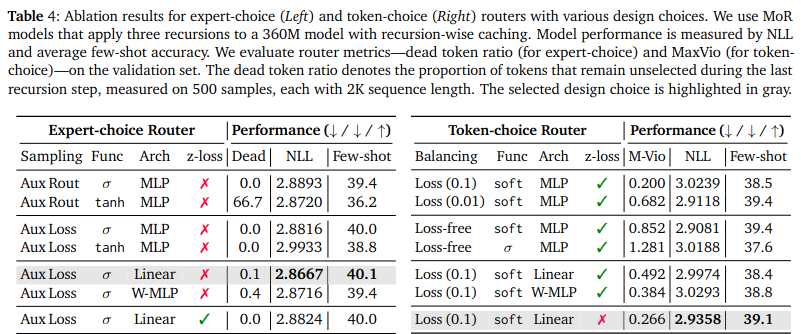

# Efficient Architectures for Large Language Models

Main article:

https://arxiv.org/pdf/2508.09834

## Linear Sequence Modeling

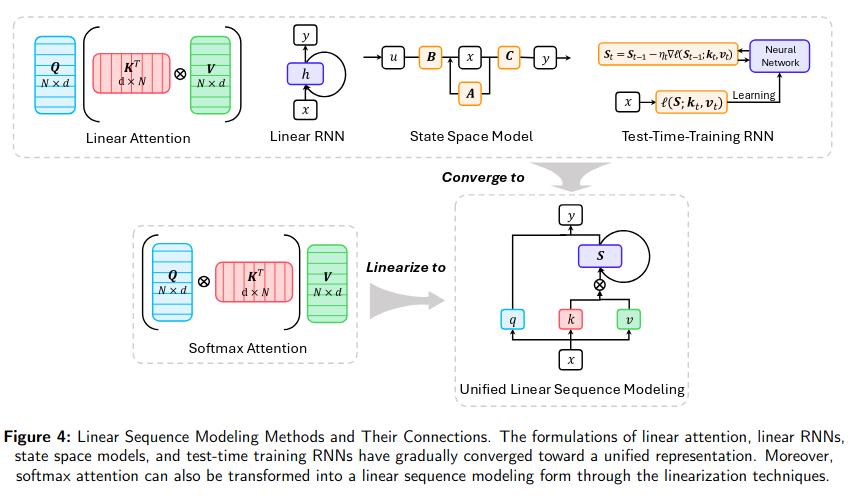

### Linear Attention

See also: *Transformers and Language models part 1 -> Effective transformers -> Linear Transformer*

Main idea: replace the standard softmax attention with a linear approximation based on feature maps or kernel functions. This modification addresses the computational inefficiencies of conventional attention mechanisms and enables linear-time
complexity. The generalized form of attention using an arbitrary similarity function can be expressed as:

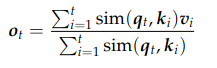

Where sim is similarity function and q, k and v are query, key and value embeddings. In vanilla transformer sim(q, k) = exp(qk<sup>T</sup>). Linear attention introduces kernel-based function to represent sim(q, k) as ϕ(q)ϕ(k)<sup>T</sup>

Then Equation above can be rewritten as:

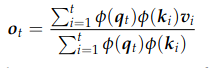

And can be further simplified to:

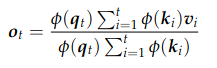

Then:

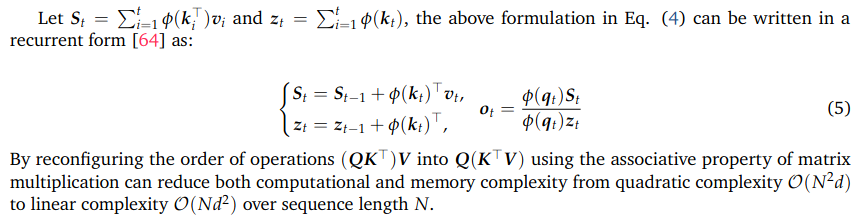



### Linear RNN

Main idea: remove nonlinearity from RNN because Traditional RNNs unalbe conduct parallel training and have low efficiency because update of hidden state involves matrix multiplication and nonlinear activation functions which not only leads to gradient issues but also prevents parallel training. 

Vanilla RNN formula is:



Where h<sub>t-1</sub> - previous hidden state, f() - projection function and σ() - activation function.

Typical Linear RNN is formulated as follows:

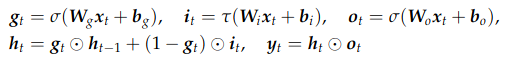

 - element-wise product

Since linear RNN removes nonlinearity, it enables efficient parallelized training and achieve linear recurrent inference for sequence modeling.

### State Space Model (SSM)

See: *Transformers and Language models part 2 -> Effective transformers -> Hybrid H3, SSM, Mamba*

### Test-Time-Training RNN

These models treat the model’s state matrices directly as fast-adapting weights, which are updated through a learnable optimizer. From this perspective, the model is no longer restricted to a fixed linear or bilinear kernel but can instead leverage more advanced optimization algorithms to gain stronger expressive power.

In terms of formulation, this class of models abandons closed-form recurrent representations and instead expresses the model directly in an online learning paradigm, similar to early meta-learning and fast weight programming

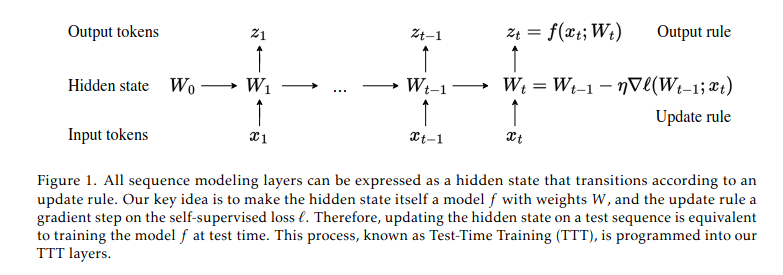

### Linear Modeling from Memory Perspective

#### Linear Update Rule (Linear RNN, Linear Attention, SSM)

Distills higher-level representations into a fixed-size hidden state to enhance generalization.

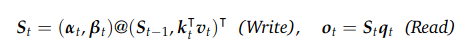

#### Billinear Update Rule (SSM)

These systems are linear with respect to state and input individually, but nonlinear overall
due to the product term (e.g., Sk). They are regarded as a special class of nonlinear systems that preserve
controllability

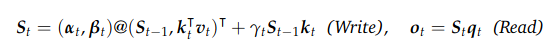

#### Nonlinear Update Rule (TTT)

These models employ nonlinear operations for state memory (such as nonlinear activations in a two-layer MLP memory),
resulting in inherently nonlinear dynamics. While this provides theoretically stronger expressiveness, these
models are constrained by block-wise parallel computation and can only be updated via minibatch gradient
descent, which leads to very low hardware utilization (less than 5%). 

### Comparsion of Linear Sequence Models

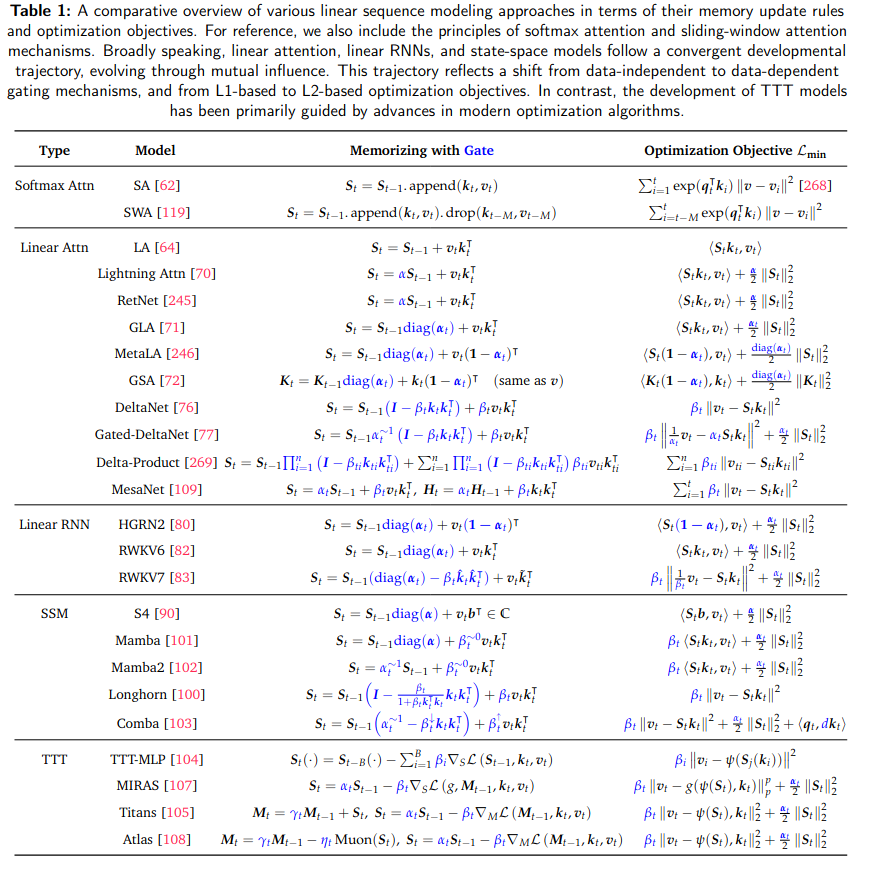

### Linearization

Main idea: convert the pretrained transformer-based LLM architecture into a linear recurrent structure using less training and
fine-tuning costs, and restore the capabilities of the original model on natural language understanding and
generation scenarios

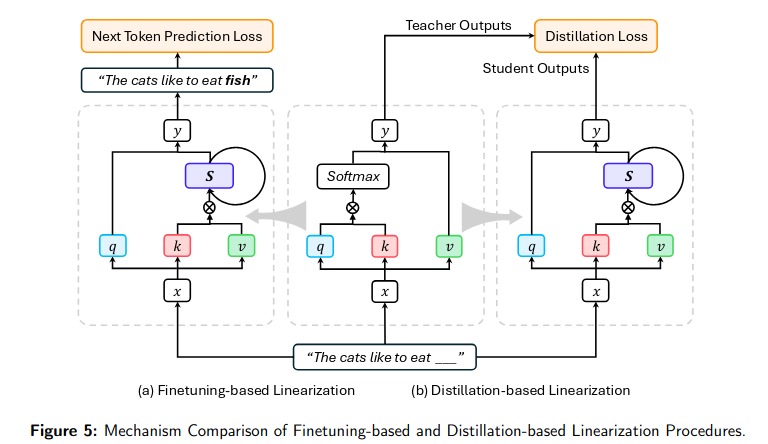

#### Finetuning-based Linearization.

Main idea: directly replaces standard softmax attention with linear sequence modeling in a pre-trained transformer, then finetune the modified model for
architecture adaption without relying on knowledge from external models.

#### Distillation-based Linearization.

Main idea: use knowledge distillation to transfer the capabilities of a pre-trained transformer with standard softmax attention as a teacher model to a
student model with linear sequence modeling.

### Hardware-efficient Implementations

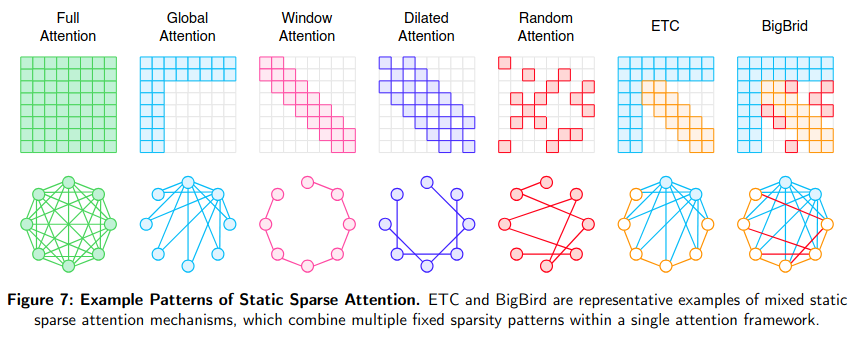

## Sparse Sequence Modeling

Sparse sequence modeling is a paradigm designed to enhance the efficiency of processing sequential data
by limiting interactions between elements to a strategically chosen subset. A typical example is sparse
attention mechanism in transformer models, which addresses the computational bottlenecks of traditional
full attention methods while aiming to preserve modeling performance.

### Static Sparse Attention

Main idea: static sparse attention reduces computational complexity by restricting each token to attend to a predefined, fixed subset of other tokens. These static patterns are designed before training and remain unchanged during inference, making them highly efficient and easy to deploy. Common structural partterns include global, window, strided, dilated, random and blockwise sparsity.

### Dynamic Sparse Attention
Main idea: dynamic sparse mechanisms determine attention patterns adaptively based on
the input content. These models aim to approximate the expressiveness of full attention by focusing compu-
tation on a dynamically selected subset of token interactions, thereby retaining task-relevant information
over long contexts while minimizing computational overhead.


## Efficient Full Attention

### Flash Attention-1/2/3

See *Transformers and Language models part 1 -> Effective transformers -> Flash Attention*

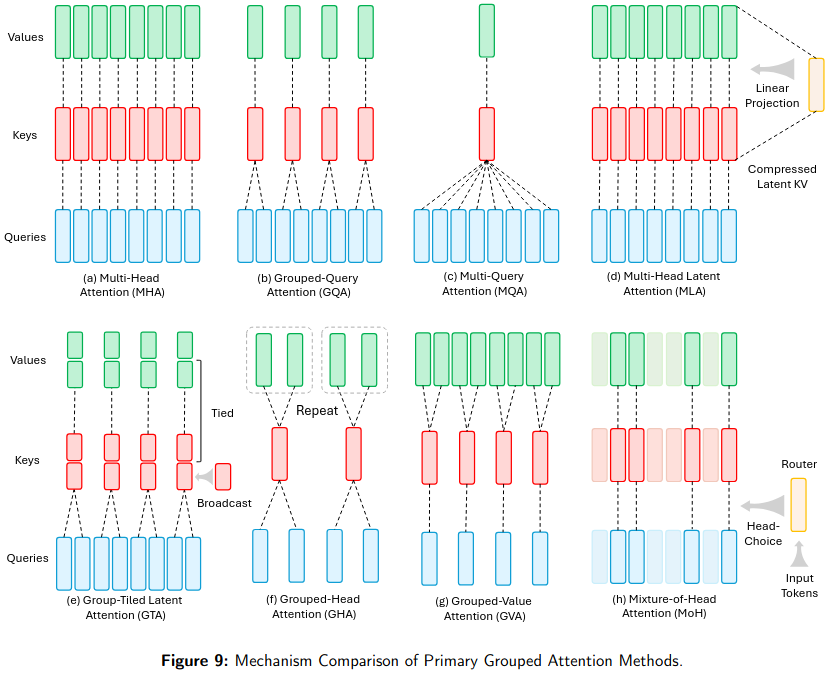

### Grouped Attention

See *Transformers and Language models part 2 -> DeepSeekv2 -> MLA vs Grouped Query Attention (GQA) vs Multi Query Attention (MQA)*

#### Group Tied Attention (GTA)

Main idea: tie the Key and Value representations into a single shared projection, which is then reused across small groups of query heads.
This design not only reduces the KV cache size by approximately 2× but also improves arithmetic intensity by
minimizing memory movement relative to compute. A critical innovation in GTA lies in its careful handling
of Rotary Position Embeddings (RoPE): only half of the tied KV state is used for the non-RoPE part of the
key, while a separate smaller head computes the RoPE-associated component, which is broadcast across the group. 

#### Group Latent Attention (GLA)

GLA extends the idea of latent compression in MLA by improving its compatibility with tensor parallelism.
While MLA compresses the KV cache into a single latent representation, this compression limits its ability to
parallelize efficiently, often requiring cache duplication across devices. GLA resolves this by sharding the
latent KV cache into multiple segments, such as two halves, and assigning separate groups of query heads to
each shard. Local attention is independently computed within each group and later merged, eliminating the
need for full cache replication and enabling better performance in distributed and imbalanced workloads.

#### Mixture of Attention (MoA)

Main idea: assign different sparse attention patterns to each head and layer within a Transformer. By automatically selecting head-wise sparsity from a pool of patterns, MoA significantly extends the effective context length while improving throughput and reducing memory consumption. This early work emphasized the benefits of heterogeneous attention structures, highlighting that not all tokens or heads require uniform computation.

#### Mixture of Heads (MoH)

Similar to MoA, but instead of discrete routing, it used soft selection: each token computes a weighted combination of attention heads, enabling partial pruning while improving or maintaining accuracy.

### Quantized Attention

#### Post-training Quantized Attention

Main idea: convert the Transformer attention operators to low-bit arithmetic without any retraining. For example, SageAttention
quantizes the QK<sup>T</sup> product to INT8 format (with per-channel smoothing of outliers) while keeping the
(softmax(QK<sup>T</sup>), V) matmul in FP16. This mixed-precision approach (INT8 for the first matmul, FP16 for
the second matmul) doubles the matmul computation speed on GPUs with negligible accuracy loss. 

#### Quantization-Aware Training for Attention

Main idea: embed low precision into training so the model learns to cope with reduced bit-width. For example, Q8BERT finetunes BERT
under 8-bit constraints (8-bit weights and activations) and can compress BERT by 4× with minimal loss.

#### Mixed-Precision Attention

Main idea: mix precisions within the attention computation to balance speed and accuracy. SageAttention is example again.
TurboAttention’s FlashQ is also a form of hybrid attention: it applies separate quantization to each
head (one scale per head) so that most matmuls run in low precision, while still using sufficient precision to
compress the KV cache. Other schemes similarly choose mixed precision by layer or token: for example, 
some layers might be run in INT8 while others (or certain operations like softmax normalization) remain FP16. 

#### INT8 Fused Attention Kernels

Beyond algorithmic tricks, specialized INT8 attention kernels have been developed. 
INT-FlashAttention is one example: it provides a fused CUDA kernel that takes INT8
Q, K, V and softmax inputs, performs all matmuls and softmax in 8-bit, and outputs FP16 or FP32 results.

## Sparse Mixture-of-Experts

Unlike conventional model ensembling, MoE is comprised of a gate and many specialized experts. The gate is a router that accepts input tokens and
adaptively selects the most relevant experts, which brings better robustness

### Routing Mechanisms

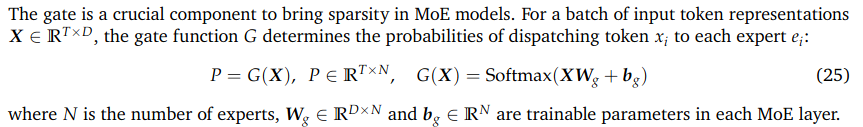

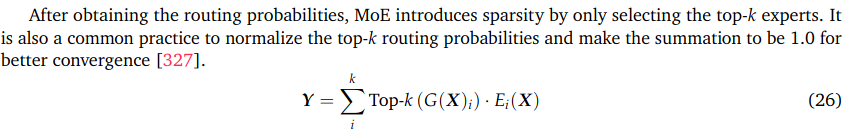

### Routing Strategies

- **token choice**: token would selects corresponding k experts to calculate new representations
- **expert choice**: Top-k operation function in equation above selects top k tokens for each expert, leading to perfect load balancing

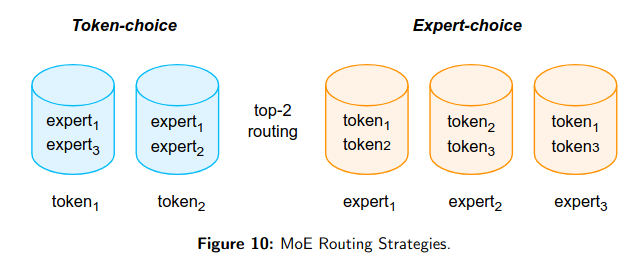

### Adaptive Top-k Routing

- **differentiable activation**: replaces the traditional top-k & softmax router with differentiable activation functions, such as ReLU and sigmoid
- **expert activation estimation**: reforms the top-k routing to be directly adaptive with dynamic k estimation; for example MoE-Dynamic selects experts by a predefined confidence score p, and the gate would incorporate experts in a descending order of their selection probabilities until the cumulative score of the chosen experts exceeds p
- **zero computational experts**: add heterogeneous experts with zero or few computational costs as placeholders; for example MoE++ keeps the number of activated experts k unchanged, and devises zero computational experts. By introducing heterogeneous load balancing across normal experts and these zero computational experts, some tokens would skip the computation process and therefore improve the overall efficiency

### Load Balancing

Gate load is the number of tokens routed to each expert. Such Routing Strategies like Token-choice routing is prone to be unbalanced due to biased gates, where an expert may be selected by many tokens and other experts may process less tokens. This phenomenon would make MoE collapses where some experts are not sufficiently trained. Furthermore, unbalanced routing would result in slow training because experts with less tokens may wait for other experts to finish processing.

A common practice for addressing unbalanced routing is to add an auxiliary load balancing loss L<sub>aux</sub> as a soft balance constraint, and the final optimization object of LLM training would be the summation of a cross-entropy loss L<sub>ce</sub> for language modeling and the auxiliary loss L<sub>aux</sub> for load balancing.

### Expert Architectures

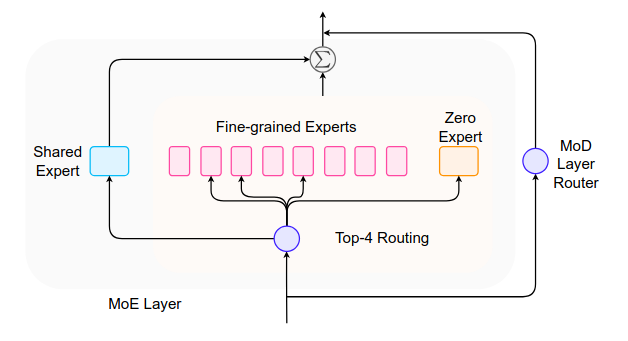

- **Fine-grained Experts**: more small experts which brings more combinations and better performance with a clear scaling property
- **Shared Experts**: fixed experts where tokens are always routed to
- **Mixture-of-Depths**: regards transformer layers as experts and select top-k tokens for each layer with a corresponding router; thus it significantly reduces the
computational cost by consuming less tokens on each layer

## Hybrid Architectures

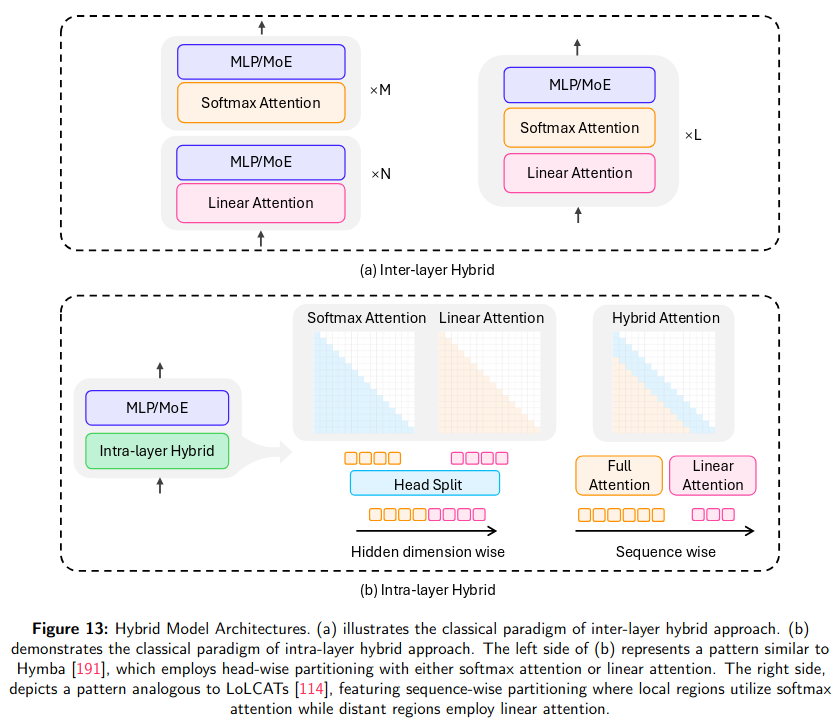

- **Inter-layer Hybrid**: employs a hierarchical alternating approach, where softmax attention layers are inserted at specific intervals between consecutive linear sequence modeling layers. This approach ensures that the majority of layers retain linear computational complexity while still benefiting from the high representational capability of softmax attention layers.
- **Intra-layer Hybrid**: achieves fine-grained fusion within individual layers by strategically blending linear sequence modeling layers with softmax attention transformer layers.
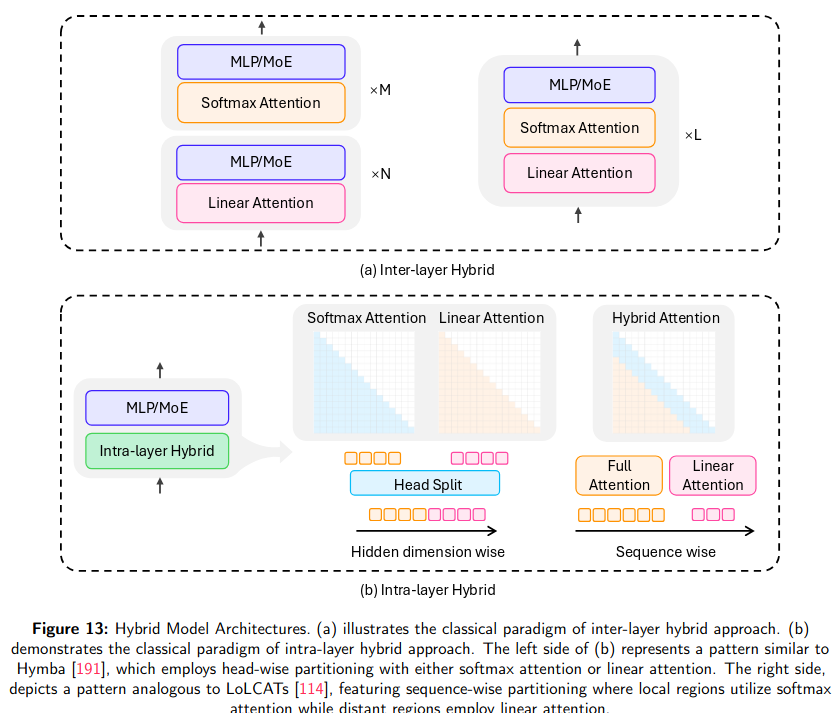

## Diffusion Large Language Models (DLLM)

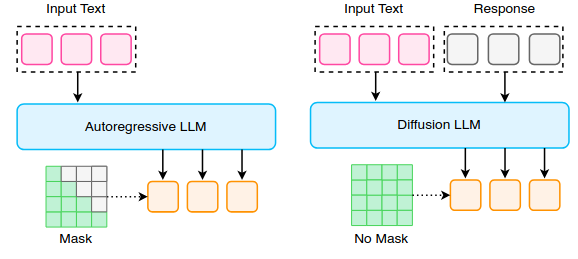

Main idea: generate text by progressively denoising a sequence from a noisy or masked state to a coherent output. 
This fundamental shift in generation enables several unique advantages. Most notably, Diffusion LLMs support parallel decoding, allowing multiple tokens
to be produced at each refinement step, which significantly reduces inference latency by avoiding sequential
token generation. Moreover, the formulation of text generation within Diffusion LLMs as a denoising or infilling process over a fixed-length canvas inherently provides superior controllability. This allows the model to better adhere to specific output constraints, such as length, format, or structure, challenges that
are difficult to address with standard autoregressive methods. Finally, Diffusion LLMs utilize bidirectional attention, enabling the model to access and revise context across the entire sequence at every step. This global view helps mitigate issues such as the reversal curse, which arise from the unidirectional nature of
autoregressive decoding.

Types of DLLM:
- **Non-Autoregressive Diffusion LLM**
- **Autoregressive Diffusion LLM** - autoregressively output block-by-block while performing diffusion within each block. By synergizing diffusion and autoregressive paradigms, this hybrid approach remedies the fixed-length constraint of the DLLM and the high inference latency of the AR LLM. 